##### This notebook is used to characterize base DDM fits to the zero correlation conditon across all groups.


Produces Figure 6 - Supplement 1

Normative evidence weighting and accumulation in correlated environments. Tardiff et al. (2024).

Nathan Tardiff
05/28/24

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
import pandas as pd
import pickle
import copy
import itertools
from matplotlib import rc
from os import path
from datetime import date
from itertools import product
from ddm import Sample
from ddm.functions import fit_adjust_model, display_model, solve_partial_conditions
import models_corr
import gddmwrapper as gdw
import ddm_corr_subj as ddm_corr
from ddm import set_N_cpus

%config InlineBackend.figure_formats = ['svg']

In [2]:
#global font settings
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
#rc('font',**{'family':'serif','serif':['Times']})
#rc('text', usetex=False)
plt.rcParams['font.size'] = 10.0
plt.rcParams["figure.labelsize"] = 11.0 #supxlabel/supylabel
plt.rcParams["figure.titlesize"] = 12.0 #title/suptitle
plt.rcParams['legend.fontsize'] = 8.0
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['mathtext.fontset'] = 'custom' #so uses same font as normal text for math/symbols

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [3]:
set_N_cpus(4)
fit_dir = './data/fits'
fit_dir0 = path.join(fit_dir,'base0'); #fit directory for the zero corr fits to establish need for collapsing bound
fig_dir = './Manuscript/Figure set draft/figs_raw'
data_dir = './data/'
data_files = {0.2:'r02_May10_parsed_data.csv',
              0.4:'r04_Apr8_Apr11_parsed_data.csv',
              0.6:'r06_Jan11_Jan17_Apr6_parsed_data.csv',
              0.8:'r08_Apr7_parsed_data.csv'}
#sess = 'Jan11+17'

#r_colors = dict(zip([-1.0,0.0,1.0],mcolors.TABLEAU_COLORS.keys())) #{-0.6:'tab:blue',0.0:'tab:orange',0.6:'tab:green'}
cmap = mpl.colormaps['RdBu'](np.linspace(0,1,20))
r_colors = dict(zip([-1.0,0.0,1.0], [cmap[0],(0.0,0.0,0.0,1.0),cmap[-1]]))

#we'll use this
idx = pd.IndexSlice
cm = 1/2.54  # centimeters in inches

In [4]:
#helper function for figure sizing
#from:https://stackoverflow.com/questions/44970010/axes-class-set-explicitly-size-width-height-of-axes-in-given-units

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    
#plot fits for all subjects
def plot_psycho_chrono_subj(psychodf,chronodf,r_colors=r_colors,medianRT=False,mod_suffix=[''],mod_line=['-'],alpha=1,
                           RT_err=True):
    if isinstance(mod_suffix,str):
        mod_suffix = [mod_suffix]
    if isinstance(mod_line,str):
        mod_line = [mod_line]        
    multi_cond = (list(r_colors.keys())==[-1.0,0.0,1.0])
    
    for (s,d),(_,dc) in zip(psychodf.groupby('subject'),chronodf.groupby('subject')):
        fig,ax = plt.subplots(nrows=1,ncols=2+RT_err)
        d.reset_index(level='subject',drop=True,inplace=True)
        dc.reset_index(level='subject',drop=True,inplace=True)
        for (r,dd),(rr,ddc) in zip(d.groupby('rho'),dc.groupby('rho')):
            #plot psycho
            assert r==rr
            r_col = np.sign(r) if multi_cond else r
            #print(r)
            dd.index=dd.index.droplevel(['rho','mu'])
            ax[0].errorbar(dd.index,dd['response']['mean'],dd['response']['sem'],
                            marker='.',linestyle='',color=r_colors[r_col],label=r,markersize=12,elinewidth=2)
            for m,l in zip(mod_suffix,mod_line):
                ax[0].plot(dd['pred_response' + m]['mean'],linestyle=l,color=r_colors[r_col],alpha=alpha)

            set_size(12,4,ax[0])
            ax[0].legend()
            ax[0].set_xlabel('evidence strength')
            ax[0].set_ylabel('proportion choose right')
            ax[0].set_title(s)

            #plot chrono
            ddc.index=ddc.index.droplevel(['rho','mu'])
            chrono_corr = ddc.xs(1.0,level='correct')
            chrono_err = ddc.xs(0.0,level='correct')

            if medianRT:
                ax[1].plot(chrono_corr['RT']['median'],
                               marker='.',linestyle='',color=r_colors[r_col],label=r,markersize=12)
            else:
                ax[1].errorbar(chrono_corr.index,chrono_corr['RT']['mean'],chrono_corr['RT']['sem'],
                               marker='.',linestyle='',color=r_colors[r_col],label=r,markersize=12,elinewidth=2)
                
            for m,l in zip(mod_suffix,mod_line):
                ax[1].plot(chrono_corr['mean_RT_corr'+m]['mean'],linestyle=l,color=r_colors[r_col])
                
            set_size(12,4,ax[1])
            ax[1].set_xlabel('evidence strength')
            ax[1].set_ylabel('mean RT (sec, correct trials)')
            
            if RT_err:
                if medianRT:
                    ax[2].plot(chrono_err['RT']['median'],
                       marker='.',linestyle='',color=r_colors[r_col],label=r,markersize=12)
                else:
                    ax[2].errorbar(chrono_err.index,chrono_err['RT']['mean'],chrono_err['RT']['sem'],
                                   marker='.',linestyle='',color=r_colors[r_col],label=r,markersize=12,elinewidth=2)
                for m,l in zip(mod_suffix,mod_line):
                    ax[2].plot(chrono_err['mean_RT_err' + m]['mean'],linestyle=l,color=r_colors[r_col],alpha=alpha)

                ax[2].set_xlabel('evidence strength')
                ax[2].set_ylabel('mean RT (sec, error trials)')
                set_size(12,4,ax[2])
            
def plot_psycho_chrono_ave(psychodf,chronodf,r_colors=r_colors,mod_suffix=[''],mod_line=['-'],alpha=1,RT_err=True,
                           ax=None,ax_labels=True):
    if isinstance(mod_suffix,str):
        mod_suffix = [mod_suffix]
    if isinstance(mod_line,str):
        mod_line = [mod_line]        
    multi_cond = (list(r_colors.keys())==[-1.0,0.0,1.0])
    
    if ax is None:
        fig,ax = plt.subplots(nrows=1,ncols=2+RT_err)
    else:
        fig = None
                
    for (r,dd),(rr,ddc) in zip(psychodf.groupby('rho'),chronodf.groupby('rho')):
        #plot psycho
        assert r==rr
        r_col = np.sign(r) if multi_cond else r
        dd.index=dd.index.droplevel(['rho'])
        ax[0].errorbar(dd.index,dd['response']['mean'],dd['response']['sem'],
                        marker='.',linestyle='',color=r_colors[r_col],label=r,markersize=12,elinewidth=2,alpha=alpha)
        #ax[0].plot(dd.index,dd['pred_response']['mean'],linestyle='-',color=r_colors[r_col])
        for m,l in zip(mod_suffix,mod_line):
            ax[0].plot(dd['pred_response' + m]['mean'],linestyle=l,color=r_colors[r_col],alpha=alpha)

        set_size(12,4,ax[0])
        ax[0].legend()
        if ax_labels:
            ax[0].set_xlabel('evidence strength')
            ax[0].set_ylabel('proportion choose right')

        #plot chrono
        ddc.index=ddc.index.droplevel(['rho'])
        chrono_corr = ddc.xs(1.0,level='correct')
        chrono_err = ddc.xs(0.0,level='correct')
        
        ax[1].errorbar(chrono_corr.index,chrono_corr['RT']['mean'],chrono_corr['RT']['sem'],
                       marker='.',linestyle='',color=r_colors[r_col],label=r,markersize=12,elinewidth=2,alpha=alpha)
        
        for m,l in zip(mod_suffix,mod_line):
            ax[1].plot(chrono_corr['mean_RT_corr'+m]['mean'],linestyle=l,color=r_colors[r_col],alpha=alpha)
            
        set_size(12,4,ax[1])
        if ax_labels:
            ax[1].set_xlabel('evidence strength')
            ax[1].set_ylabel('mean RT (sec, correct trials)')
        
        if RT_err:
            ax[2].errorbar(chrono_err.index,chrono_err['RT']['mean'],chrono_err['RT']['sem'],
                           marker='.',linestyle='',color=r_colors[r_col],label=r,markersize=12,elinewidth=2)

            for m,l in zip(mod_suffix,mod_line):
                ax[2].plot(chrono_err['mean_RT_err' + m]['mean'],linestyle=l,color=r_colors[r_col],alpha=alpha)
            
            if ax_labels:
                ax[2].set_xlabel('evidence strength')
                ax[2].set_ylabel('mean RT (sec, error trials)')
            set_size(12,4,ax[2])
    
    return ax if fig is None else fig,ax

In [5]:
#read in data
data = {}
#for i,(f,c) in enumerate(zip(data_files,data_conds)):
for r,f in data_files.items():
    data[r] = pd.read_csv(path.join(data_dir,f))
    data[r]['rho_cond'] = r
    #data.append(pd.read_csv(path.join(data_dir,f)))
    #data[i]['cond'] = c
    #data.append(this_data)

data = pd.concat(data.values(),ignore_index=True)

#there shouldn't be any missing data from these files but let's check
assert not data.isnull().values.any(), "Missing data detected!"
display(data.head())
#now let's clean up column names
#data.rename(columns={'r':'rho','MeanMain':'mu','participant':'subject'},inplace=True)
#data.drop(['Unnamed: 0','index'],axis=1,inplace=True)
data.rename(columns={'Unnamed: 0':'trial','r':'rho','MeanMain':'mu','participant':'subject','SNR':'SNRraw'},inplace=True)
data.drop('index',axis=1,inplace=True)

#let's fix the trial column so it is actually reflecting trial numbers reset per subject (should probably ask Jiwon to do this)
data['trial'] = np.int32(data.groupby('subject')['trial'].rank())
display(data.head())

subj = data[['subject','rho_cond']].drop_duplicates().sort_values('subject')
subj.reset_index(inplace=True,drop=True)
display(subj)
print(len(subj))
print(subj.rho_cond.value_counts())
assert not subj.subject.duplicated().any()

,Unnamed: 0,index,participant,r,MeanMain,RT,response,correct,SNR,threshold,rho_cond
0,0,5993,5f3ee36d0306de1a411882a5,0.2,0.02069,1.6825,1.0,1.0,0.142692,0.356901,0.2
1,1,6004,5f3ee36d0306de1a411882a5,-0.2,-0.04224,2.0112,0.0,1.0,-0.892109,0.356901,0.2
2,2,6017,5f3ee36d0306de1a411882a5,0.0,-0.01889,2.4702,0.0,1.0,-0.142733,0.356901,0.2
3,3,6030,5f3ee36d0306de1a411882a5,0.0,0.01889,2.4292,1.0,1.0,0.142733,0.356901,0.2
4,4,6048,5f3ee36d0306de1a411882a5,0.2,-0.02069,3.5572,0.0,1.0,-0.142692,0.356901,0.2


,trial,subject,rho,mu,RT,response,correct,SNRraw,threshold,rho_cond
0,1,5f3ee36d0306de1a411882a5,0.2,0.02069,1.6825,1.0,1.0,0.142692,0.356901,0.2
1,2,5f3ee36d0306de1a411882a5,-0.2,-0.04224,2.0112,0.0,1.0,-0.892109,0.356901,0.2
2,3,5f3ee36d0306de1a411882a5,0.0,-0.01889,2.4702,0.0,1.0,-0.142733,0.356901,0.2
3,4,5f3ee36d0306de1a411882a5,0.0,0.01889,2.4292,1.0,1.0,0.142733,0.356901,0.2
4,5,5f3ee36d0306de1a411882a5,0.2,-0.02069,3.5572,0.0,1.0,-0.142692,0.356901,0.2


,subject,rho_cond
0,575f387c91f8b40006c332e1,0.4
1,58f82417edbd82000169bce8,0.8
2,5b232f6838fc0c000131438c,0.6
3,5b3455bf532e3d00018e6e8b,0.8
4,5b477fdb56e0140001ac7720,0.8
...,...,...
95,61636a4bf1a773cc305502e7,0.6
96,616e401a1a88b28ca7581bb6,0.2
97,616f469494656434f5b4ebc6,0.2
98,6172eebe85de20b0b268d5c5,0.4


100
0.4    25
0.8    25
0.6    25
0.2    25
Name: rho_cond, dtype: int64


In [6]:
#SNR cleanup
subj_SNR_raw=data[['subject','rho','SNRraw']].drop_duplicates().sort_values(['subject','rho','SNRraw'])
assert ((subj_SNR_raw.reset_index().groupby(['subject','rho'])['SNRraw'].transform(lambda x: len(x))==4).all()), \
    'Too many SNRs detected for some subjects!'
subj_SNR_raw['rSNR']=subj_SNR_raw.groupby(['subject','rho']).rank()
#display(subj_SNR_raw.iloc[0:20])

#since there is floating-point slop between rho conds that is not fully alleviated by rounding, 
#we'll average over all rho conds to get a master set of SNR values
subj_SNR_raw=subj_SNR_raw.merge(subj_SNR_raw.groupby(['subject','rSNR'])[['SNRraw']].mean().round(2).rename({'SNRraw':'SNR'},axis=1),
                        on=['subject','rSNR']).sort_values(['subject','rho','SNR']).copy()

#subj_SNR_ave = subj_SNR_raw.groupby(['subject','rSNR'])[['SNRraw']].mean().round(2).rename({'SNRraw':'SNR'},axis=1)
display(subj_SNR_raw.iloc[0:17])

#merge SNR back into data
print(data.shape)
data = data.merge(subj_SNR_raw.drop('rSNR',axis=1),on=['subject','rho','SNRraw'],how='left')
print(data.shape)
display(data)
assert (data.SNR-data.SNRraw < .006).all(), "rounded SNRs not properly joined to data!"

,subject,rho,SNRraw,rSNR,SNR
0,575f387c91f8b40006c332e1,-0.4,-0.748167,1.0,-0.75
3,575f387c91f8b40006c332e1,-0.4,-0.119707,2.0,-0.12
6,575f387c91f8b40006c332e1,-0.4,0.119707,3.0,0.12
9,575f387c91f8b40006c332e1,-0.4,0.748167,4.0,0.75
1,575f387c91f8b40006c332e1,0.0,-0.748225,1.0,-0.75
4,575f387c91f8b40006c332e1,0.0,-0.119716,2.0,-0.12
7,575f387c91f8b40006c332e1,0.0,0.119716,3.0,0.12
10,575f387c91f8b40006c332e1,0.0,0.748225,4.0,0.75
2,575f387c91f8b40006c332e1,0.4,-0.748398,1.0,-0.75
5,575f387c91f8b40006c332e1,0.4,-0.119720,2.0,-0.12


(76757, 10)
(76757, 11)


,trial,subject,rho,mu,RT,response,correct,SNRraw,threshold,rho_cond,SNR
0,1,5f3ee36d0306de1a411882a5,0.2,0.02069,1.6825,1.0,1.0,0.142692,0.356901,0.2,0.14
1,2,5f3ee36d0306de1a411882a5,-0.2,-0.04224,2.0112,0.0,1.0,-0.892109,0.356901,0.2,-0.89
2,3,5f3ee36d0306de1a411882a5,0.0,-0.01889,2.4702,0.0,1.0,-0.142733,0.356901,0.2,-0.14
3,4,5f3ee36d0306de1a411882a5,0.0,0.01889,2.4292,1.0,1.0,0.142733,0.356901,0.2,0.14
4,5,5f3ee36d0306de1a411882a5,0.2,-0.02069,3.5572,0.0,1.0,-0.142692,0.356901,0.2,-0.14
...,...,...,...,...,...,...,...,...,...,...,...
76752,764,5e95d4f551598d01d6d455af,-0.8,-0.00788,3.7340,0.0,1.0,-0.124189,0.310849,0.8,-0.12
76753,765,5e95d4f551598d01d6d455af,0.8,0.05914,1.1230,1.0,1.0,0.777231,0.310849,0.8,0.78
76754,766,5e95d4f551598d01d6d455af,-0.8,0.00788,4.8250,0.0,0.0,0.124189,0.310849,0.8,0.12
76755,767,5e95d4f551598d01d6d455af,0.8,-0.05914,0.4020,0.0,1.0,-0.777231,0.310849,0.8,-0.78


In [7]:
#create SNR key by dropping duplicates
subj_SNR = subj_SNR_raw.drop(['rho','SNRraw'],axis=1).drop_duplicates()
#display(subj_SNR)

#add a universal SNR for aggregate data
subj_SNR=subj_SNR.merge(subj_SNR.groupby('rSNR').mean().rename({'SNR':'uSNR'},axis=1),
                        on='rSNR').sort_values(['subject','uSNR']).copy()
subj_SNR.set_index(['subject','SNR'],inplace=True)
display(subj_SNR)

#gut checks
assert (subj_SNR.reset_index().value_counts().groupby('subject').sum()==4).all(), "Incorrect number of SNRs per subject!"
assert len(subj_SNR.index.get_level_values('subject').drop_duplicates()) == len(subj), \
    "Subject mismatch between data and subj_SNR!"

/var/folders/3_/40m5_51d419__yjj36qs3p_m0001g2/T/ipykernel_7653/1817336671.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subj_SNR=subj_SNR.merge(subj_SNR.groupby('rSNR').mean().rename({'SNR':'uSNR'},axis=1),


rSNR    uSNR
subject                  SNR                
575f387c91f8b40006c332e1 -0.75   1.0 -0.9239
                         -0.12   2.0 -0.1480
                          0.12   3.0  0.1480
                          0.75   4.0  0.9239
58f82417edbd82000169bce8 -0.72   1.0 -0.9239
...                              ...     ...
6172eebe85de20b0b268d5c5  0.75   4.0  0.9239
6176846e673909995a32dce3 -0.83   1.0 -0.9239
                         -0.13   2.0 -0.1480
                          0.13   3.0  0.1480
                          0.83   4.0  0.9239

[400 rows x 2 columns]

## Make ddm samples

In [8]:
#trim data!
RTminmax = [0.3,15]
datat = data.loc[(data.RT >= RTminmax[0]) & (data.RT <= RTminmax[1])]
(len(data)-len(datat))/len(data) #percent of data trimmed is very small

0.008324973618041352

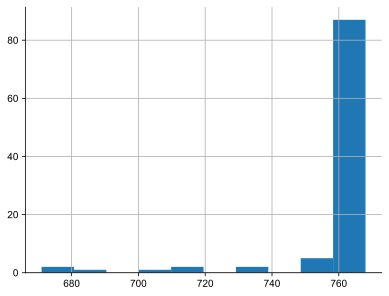

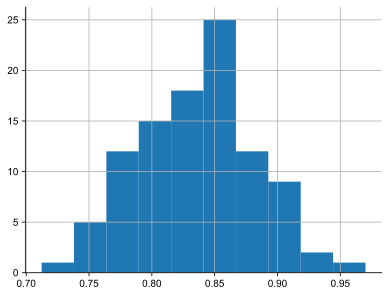

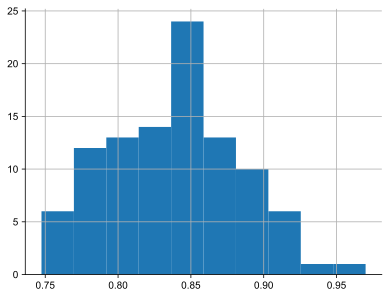

In [9]:
#general stats on amount of data per subject and subject performance
#display(data.subject.value_counts())
datat.subject.value_counts().hist()
plt.show()
data.groupby('subject').correct.mean().hist()
plt.show()
datat.groupby('subject').correct.mean().hist()
plt.show()

In [10]:
#define rho conditions for getting fits/samples later

rho_conds = datat.rho_cond.unique()
rho_conds_filestring = {r:str(r).replace('.','') for r in rho_conds}
rho_signs = np.array([-1.0,0.0,1.0])

### compute behavioral averages

In [11]:
datat_psycho_ave = \
    datat[['subject','rho','SNR','mu','response']].groupby(['subject','rho','SNR','mu']).agg(['mean','std','sem'])
display(datat_psycho_ave.groupby('rho').head())

datat_chrono_ave = \
    datat[['subject','rho','SNR','mu','correct','RT']].groupby(['subject','rho','SNR','mu','correct']).agg(['mean','std','sem'])
display(datat_chrono_ave.groupby('rho').head())

response                    
                                                  mean       std       sem
subject                  rho  SNR   mu                                    
575f387c91f8b40006c332e1 -0.4 -0.75 -0.03350  0.109375  0.314576  0.039322
                              -0.12 -0.01340  0.359375  0.483610  0.060451
                               0.12  0.01340  0.703125  0.460493  0.057562
                               0.75  0.03350  0.984375  0.125000  0.015625
                          0.0 -0.75 -0.04325  0.109375  0.314576  0.039322
                              -0.12 -0.01730  0.406250  0.495015  0.061877
                               0.12  0.01730  0.906250  0.293785  0.036723
                               0.75  0.04325  0.968750  0.175368  0.021921
                          0.4 -0.75 -0.05118  0.093750  0.293785  0.036723
                              -0.12 -0.02047  0.281250  0.453163  0.056645
                               0.12  0.02047  0.843750  0.365963  0.045745
                               0.75  0.05118  0.953125  0.213042  0.026630
58f82417edbd82000169bce8 -0.8 -0.72 -0.01897  0.066667  0.251549  0.032475
                              -0.12 -0.00759  0.403226  0.494550  0.062808
                               0.12  0.00759  0.796875  0.405505  0.050688
                               0.72  0.01897  0.951613  0.216335  0.027475
                          0.0 -0.72 -0.04241  0.015625  0.125000  0.015625
                          0.8 -0.72 -0.05690  0.063492  0.245805  0.030968
                              -0.12 -0.02276  0.317460  0.469227  0.059117
                               0.12  0.02276  0.777778  0.419079  0.052799
                               0.72  0.05690  0.967742  0.178127  0.022622
5b232f6838fc0c000131438c -0.6 -0.89 -0.02987  0.078125  0.270490  0.033811
                              -0.14 -0.01195  0.406250  0.495015  0.061877
                               0.14  0.01195  0.796875  0.405505  0.050688
                               0.89  0.02987  0.953125  0.213042  0.026630
                          0.6 -0.89 -0.05974  0.046875  0.213042  0.026630
                              -0.14 -0.02390  0.296875  0.460493  0.057562
                               0.14  0.02390  0.812500  0.393398  0.049175
                               0.89  0.05974  1.000000  0.000000  0.000000
5b3455bf532e3d00018e6e8b -0.8 -0.66 -0.01819  0.187500  0.393398  0.049175
                          0.8 -0.66 -0.05458  0.140625  0.350382  0.043798
5b5ca33f295c4b0001c294d0 -0.4 -0.81 -0.03477  0.000000  0.000000  0.000000
                          0.4 -0.81 -0.05311  0.015625  0.125000  0.015625
5b8c8e7d0c740e00019d55c3 -0.6 -0.86 -0.02938  0.062500  0.243975  0.030497
                          0.6 -0.86 -0.05877  0.031250  0.175368  0.021921
5bd781291fd7c80001bb1fad -0.2 -0.81 -0.04015  0.062500  0.243975  0.030497
                              -0.13 -0.01606  0.281250  0.453163  0.056645
                               0.13  0.01606  0.734375  0.445157  0.055645
                               0.81  0.04015  0.984375  0.125000  0.015625
                          0.2 -0.81 -0.04917  0.046875  0.213042  0.026630
                              -0.13 -0.01967  0.187500  0.393398  0.049175
                               0.13  0.01967  0.734375  0.445157  0.055645
                               0.81  0.04917  0.968750  0.175368  0.021921
5d645bf6912c630018e269e3 -0.2 -1.04 -0.04552  0.171875  0.380254  0.047532
                          0.2 -1.04 -0.05575  0.171875  0.380254  0.047532

RT            \
                                                          mean       std   
subject                  rho  SNR   mu       correct                       
575f387c91f8b40006c332e1 -0.4 -0.75 -0.03350 0.0      3.605714  1.856701   
                                             1.0      2.734781  0.882488   
                              -0.12 -0.01340 0.0      3.086874  1.135117   
                                             1.0      2.946388  1.004948   
                               0.12  0.01340 0.0      2.496626  0.843780   
                          0.0 -0.75 -0.04325 0.0      2.002286  0.751804   
                                             1.0      2.570647  0.907455   
                              -0.12 -0.01730 0.0      2.922254  1.086153   
                                             1.0      2.827755  1.218041   
                               0.12  0.01730 0.0      3.486450  1.120658   
                          0.4 -0.75 -0.05118 0.0      2.415867  1.289492   
                                             1.0      2.459212  0.947419   
                              -0.12 -0.02047 0.0      2.560089  1.108950   
                                             1.0      2.841450  1.080723   
                               0.12  0.02047 0.0      2.639440  0.818084   
58f82417edbd82000169bce8 -0.8 -0.72 -0.01897 0.0      3.699500  1.988548   
                                             1.0      2.911679  1.699150   
                              -0.12 -0.00759 0.0      3.611480  1.743437   
                                             1.0      3.066297  1.279710   
                               0.12  0.00759 0.0      3.047923  0.833213   
                          0.8 -0.72 -0.05690 0.0      2.891750  1.169060   
                                             1.0      2.568153  1.000523   
                              -0.12 -0.02276 0.0      3.183400  1.449378   
                                             1.0      2.955535  1.149211   
                               0.12  0.02276 0.0      2.760357  1.794017   
5b232f6838fc0c000131438c -0.6 -0.89 -0.02987 0.0      4.957400  2.912065   
                                             1.0      2.915008  1.176968   
                              -0.14 -0.01195 0.0      3.624435  2.355111   
                                             1.0      3.045018  1.676974   
                               0.14  0.01195 0.0      2.876669  1.571359   
                          0.6 -0.89 -0.05974 0.0      1.477633  0.249984   
                                             1.0      2.724497  1.460335   
                              -0.14 -0.02390 0.0      3.673842  2.460267   
                                             1.0      3.078538  2.174258   
                               0.14  0.02390 0.0      3.566825  2.188608   
5bd781291fd7c80001bb1fad -0.2 -0.81 -0.04015 0.0      2.806550  1.100412   
                                             1.0      1.994917  0.671982   
                              -0.13 -0.01606 0.0      2.689339  0.793360   
                                             1.0      2.041659  0.551630   
                               0.13  0.01606 0.0      2.491012  0.884248   
                          0.2 -0.81 -0.04917 0.0      2.370533  0.696690   
                                             1.0      1.967684  0.674544   
                              -0.13 -0.01967 0.0      2.643167  0.740102   
                                             1.0      2.101046  0.610086   
                               0.13  0.01967 0.0      2.224988  0.505722   

                                                                
                                                           sem  
subject                  rho  SNR   mu       correct            
575f387c91f8b40006c332e1 -0.4 -0.75 -0.03350 0.0      0.701767  
                                             1.0      0.116888  
                              -0.12 -0.01340 0.0      0.236688  
                     

In [12]:
#now create RT normed by rho==0.0 RT (averaged across all data per subj, separate for correct/error)
#I couldn't figure out how to do this w/o a join, but it FEELs like one should. Though I guess join is safest...

# datat_r0_chrono_ave = \
#     datat.loc[datat.rho==0.0,['subject','correct','RT']].groupby(['subject','correct']).agg(['mean'])
# display(datat_r0_chrono_ave.head())

datat_r0_SNR_chrono_ave = \
    datat.loc[datat.rho==0.0,['subject','correct','SNR','RT']].groupby(['subject','correct','SNR']).agg(['mean'])
display(datat_r0_SNR_chrono_ave.head())
datat_r0_chrono_ave = datat_r0_SNR_chrono_ave.xs('mean',axis=1,level=1).groupby(['subject','correct']).agg(['mean'])
display(datat_r0_chrono_ave.head())

RT_norm = datat_chrono_ave[[('RT','mean')]] - datat_r0_chrono_ave[[('RT','mean')]]
datat_chrono_ave= datat_chrono_ave.join(RT_norm,rsuffix='_norm0')
display(datat_chrono_ave.head())

RT
                                            mean
subject                  correct SNR            
575f387c91f8b40006c332e1 0.0     -0.75  2.002286
                                 -0.12  2.922254
                                  0.12  3.486450
                                  0.75  2.731550
                         1.0     -0.75  2.570647

RT
                                      mean
subject                  correct          
575f387c91f8b40006c332e1 0.0      2.785635
                         1.0      2.650590
58f82417edbd82000169bce8 0.0      2.449071
                         1.0      2.791224
5b232f6838fc0c000131438c 0.0      3.230544

RT            \
                                                         mean       std   
subject                  rho  SNR   mu      correct                       
575f387c91f8b40006c332e1 -0.4 -0.75 -0.0335 0.0      3.605714  1.856701   
                                            1.0      2.734781  0.882488   
                              -0.12 -0.0134 0.0      3.086874  1.135117   
                                            1.0      2.946388  1.004948   
                               0.12  0.0134 0.0      2.496626  0.843780   

                                                               RT_norm0  
                                                          sem      mean  
subject                  rho  SNR   mu      correct                      
575f387c91f8b40006c332e1 -0.4 -0.75 -0.0335 0.0      0.701767  0.820079  
                                            1.0      0.116888  0.084191  
                              -0.12 -0.0134 0.0      0.236688  0.301239  
                                            1.0      0.156947  0.295798  
                               0.12  0.0134 0.0      0.193576 -0.289009

In [13]:
datat_psycho_ave_all = \
    datat_psycho_ave.xs('mean',axis=1,level=1).join(subj_SNR,
                                      on=['subject','SNR']).groupby(['rho','uSNR']).agg(['mean','std','sem'])
display(datat_psycho_ave_all)

datat_chrono_ave_all = \
    datat_chrono_ave.xs('mean',axis=1,level=1).join(subj_SNR,
                                      on=['subject','SNR']).groupby(['rho','uSNR','correct']).agg(['mean','std','sem'])
display(datat_chrono_ave_all)

response                     rSNR          
                  mean       std       sem mean  std  sem
rho  uSNR                                                
-0.8 -0.9239  0.095098  0.061610  0.012322  1.0  0.0  0.0
     -0.1480  0.289612  0.111452  0.022290  2.0  0.0  0.0
      0.1480  0.711479  0.089335  0.017867  3.0  0.0  0.0
      0.9239  0.924907  0.051747  0.010349  4.0  0.0  0.0
-0.6 -0.9239  0.081639  0.052622  0.010524  1.0  0.0  0.0
     -0.1480  0.283473  0.090698  0.018140  2.0  0.0  0.0
      0.1480  0.752392  0.071163  0.014233  3.0  0.0  0.0
      0.9239  0.916485  0.047024  0.009405  4.0  0.0  0.0
-0.4 -0.9239  0.053611  0.047643  0.009529  1.0  0.0  0.0
     -0.1480  0.227794  0.122965  0.024593  2.0  0.0  0.0
      0.1480  0.769287  0.090160  0.018032  3.0  0.0  0.0
      0.9239  0.941389  0.043959  0.008792  4.0  0.0  0.0
-0.2 -0.9239  0.085252  0.050260  0.010052  1.0  0.0  0.0
     -0.1480  0.283214  0.081900  0.016380  2.0  0.0  0.0
      0.1480  0.739003  0.074175  0.014835  3.0  0.0  0.0
      0.9239  0.917261  0.059933  0.011987  4.0  0.0  0.0
 0.0 -0.9239  0.075545  0.056731  0.005673  1.0  0.0  0.0
     -0.1480  0.267933  0.096548  0.009655  2.0  0.0  0.0
      0.1480  0.772412  0.080849  0.008085  3.0  0.0  0.0
      0.9239  0.932959  0.053089  0.005309  4.0  0.0  0.0
 0.2 -0.9239  0.085672  0.057869  0.011574  1.0  0.0  0.0
     -0.1480  0.277182  0.071597  0.014319  2.0  0.0  0.0
      0.1480  0.759754  0.074592  0.014918  3.0  0.0  0.0
      0.9239  0.919718  0.039722  0.007944  4.0  0.0  0.0
 0.4 -0.9239  0.066985  0.050029  0.010006  1.0  0.0  0.0
     -0.1480  0.232314  0.107188  0.021438  2.0  0.0  0.0
      0.1480  0.773078  0.093741  0.018748  3.0  0.0  0.0
      0.9239  0.950303  0.038987  0.007797  4.0  0.0  0.0
 0.6 -0.9239  0.065321  0.041583  0.008317  1.0  0.0  0.0
     -0.1480  0.261880  0.091798  0.018360  2.0  0.0  0.0
      0.1480  0.758433  0.077942  0.015588  3.0  0.0  0.0
      0.9239  0.947710  0.043345  0.008669  4.0  0.0  0.0
 0.8 -0.9239  0.060619  0.041266  0.008253  1.0  0.0  0.0
     -0.1480  0.257721  0.087919  0.017584  2.0  0.0  0.0
      0.1480  0.785974  0.073793  0.014759  3.0  0.0  0.0
      0.9239  0.951316  0.037494  0.007499  4.0  0.0  0.0

RT                      RT_norm0            \
                          mean       std       sem      mean       std   
rho  uSNR    correct                                                     
-0.8 -0.9239 0.0      3.255500  1.792148  0.358430  0.805786  1.504709   
             1.0      2.903680  0.843171  0.168634  0.470057  0.369767   
     -0.1480 0.0      3.839407  1.417452  0.283490  1.389693  0.988517   
             1.0      3.445038  1.091729  0.218346  1.011416  0.544051   
      0.1480 0.0      3.371822  1.332527  0.266505  0.922108  0.918590   
...                        ...       ...       ...       ...       ...   
 0.8 -0.1480 1.0      2.481942  0.802311  0.160462  0.048319  0.287145   
      0.1480 0.0      2.530168  1.059625  0.211925  0.080455  0.687738   
             1.0      2.428839  0.887333  0.177467 -0.004784  0.279658   
      0.9239 0.0      2.120885  1.752033  0.365324 -0.231899  1.684788   
             1.0      1.915635  0.510659  0.102132 -0.517987  0.338379   

                               rSNR            
                           sem mean  std  sem  
rho  uSNR    correct                           
-0.8 -0.9239 0.0      0.300942  1.0  0.0  0.0  
             1.0      0.073953  1.0  0.0  0.0  
     -0.1480 0.0      0.197703  2.0  0.0  0.0  
             1.0      0.108810  2.0  0.0  0.0  
      0.1480 0.0      0.183718  3.0  0.0  0.0  
...                        ...  ...  ...  ...  
 0.8 -0.1480 1.0      0.057429  2.0  0.0  0.0  
      0.1480 0.0      0.137548  3.0  0.0  0.0  
             1.0      0.055932  3.0  0.0  0.0  
      0.9239 0.0      0.351303  4.0  0.0  0.0  
             1.0      0.067676  4.0  0.0  0.0  

[72 rows x 9 columns]

In [14]:
#set colors
cmap_stacked = mpl.colormaps['RdBu'](np.linspace(0,1,9))
cmap_stacked[4] = [0.5,0.5,0.5,1.0]
rhos = datat_psycho_ave_all.index.get_level_values('rho').sort_values().unique().to_numpy()

r_colors_stacked = dict(zip(rhos, cmap_stacked))

# Fits

## Analyze base models for zero corr cond
Here we are just trying to determine whether fits look OK and whether collapsing bound is needed, so we're fitting basic DDMs that don't take into account correlation (except in noise term).

In [15]:
base_mods = ['base','baseCL']
sampt0,_ = gdw.load_data(datat.loc[datat.rho==0.0].copy(),rt="RT",conds=['rho','mu'],verbose=False,debug=False)
base_mod_samps = {'base':sampt0,'baseCL':sampt0,}

In [16]:
#get fit for all base models
base_fits = {}
for b in base_mods:
    base_fits[b] = gdw.load_models(path.join(fit_dir0,'%s_*o0.0_*_2023-05-??' % b),model_name=b,verbose=False)
    base_fits[b] = {m.subject:m for m in base_fits[b]}

Of 100 files, found 100 for model base.
Of 200 files, found 100 for model baseCL.


base
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solvi

Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving model for all conditions. May take a minute...
Solving mo

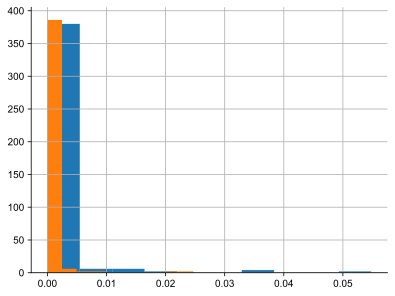

In [17]:
#now let's get predictions
base_soldf = {}
for b in base_mods:
    print(b)

    soldf = ddm_corr.get_all_sols(base_mod_samps[b],base_fits[b])
    soldf['model'] = b
    soldf['rho'] = 0.0
    #soldf.head()
    base_soldf[b] = soldf
    
#another check for duplicate subjects/models...
#maybe not the best that this is hardcoded but then again if anything changes will force me to check closely
assert [s[['subject','model']].drop_duplicates().shape[0] for s in base_soldf.values()] == [100,100], \
    "Possible duplicate subjects/models detected!"

   trial                   subject  rho       mu      RT  response  correct  \
0      3  5f3ee36d0306de1a411882a5  0.0 -0.01889  2.4702       0.0      1.0   
1     21  5f3ee36d0306de1a411882a5  0.0 -0.01889  3.4319       1.0      0.0   
2     32  5f3ee36d0306de1a411882a5  0.0 -0.01889  5.1892       1.0      0.0   
3     44  5f3ee36d0306de1a411882a5  0.0 -0.01889  1.8299       1.0      0.0   
4     56  5f3ee36d0306de1a411882a5  0.0 -0.01889  2.4705       1.0      0.0   

     SNRraw  threshold  rho_cond   SNR  mean_corr  mean_err  mean_RT_corr  \
0 -0.142733   0.356901       0.2 -0.14   0.733499  0.266501      2.846691   
1 -0.142733   0.356901       0.2 -0.14   0.733499  0.266501      2.846691   
2 -0.142733   0.356901       0.2 -0.14   0.733499  0.266501      2.846691   
3 -0.142733   0.356901       0.2 -0.14   0.733499  0.266501      2.846691   
4 -0.142733   0.356901       0.2 -0.14   0.733499  0.266501      2.846691   

   mean_RT_err model  pred_response  
0     3.073453  base    

response                     pred_response                      \
                 mean       std       sem          mean       std       sem   
rho uSNR                                                                      
0.0 -0.9239  0.075545  0.056731  0.005673      0.075305  0.042363  0.004236   
    -0.1480  0.267933  0.096548  0.009655      0.256634  0.050404  0.005040   
     0.1480  0.772412  0.080849  0.008085      0.743366  0.050404  0.005040   
     0.9239  0.932959  0.053089  0.005309      0.924695  0.042363  0.004236   

            rSNR            
            mean  std  sem  
rho uSNR                    
0.0 -0.9239  1.0  0.0  0.0  
    -0.1480  2.0  0.0  0.0  
     0.1480  3.0  0.0  0.0  
     0.9239  4.0  0.0  0.0

RT                     mean_RT_corr            \
                         mean       std       sem         mean       std   
rho uSNR    correct                                                        
0.0 -0.9239 0.0      2.259547  1.493308  0.155688     2.051587  0.657398   
            1.0      2.181604  0.735463  0.073546     2.124468  0.695126   
    -0.1480 0.0      2.728161  1.153973  0.115397     2.843819  1.053266   
            1.0      2.733466  1.054133  0.105413     2.843819  1.053266   
     0.1480 0.0      2.742214  1.166033  0.116603     2.843819  1.053266   

                              mean_RT_err                     rSNR            
                          sem        mean       std       sem mean  std  sem  
rho uSNR    correct                                                           
0.0 -0.9239 0.0      0.068538    2.305676  0.758235  0.079051  1.0  0.0  0.0  
            1.0      0.069513    2.386045  0.811331  0.081133  1.0  0.0  0.0  
    -0.1480 0.0      0.105327    2.884597  1.050968  0.105097  2.0  0.0  0.0  
            1.0      0.105327    2.884597  1.050968  0.105097  2.0  0.0  0.0  
     0.1480 0.0      0.105327    2.884597  1.050968  0.105097  3.0  0.0  0.0

   trial                   subject  rho       mu      RT  response  correct  \
0      3  5f3ee36d0306de1a411882a5  0.0 -0.01889  2.4702       0.0      1.0   
1     21  5f3ee36d0306de1a411882a5  0.0 -0.01889  3.4319       1.0      0.0   
2     32  5f3ee36d0306de1a411882a5  0.0 -0.01889  5.1892       1.0      0.0   
3     44  5f3ee36d0306de1a411882a5  0.0 -0.01889  1.8299       1.0      0.0   
4     56  5f3ee36d0306de1a411882a5  0.0 -0.01889  2.4705       1.0      0.0   

     SNRraw  threshold  rho_cond   SNR  mean_corr  mean_err  mean_RT_corr  \
0 -0.142733   0.356901       0.2 -0.14    0.72963   0.27037      2.772548   
1 -0.142733   0.356901       0.2 -0.14    0.72963   0.27037      2.772548   
2 -0.142733   0.356901       0.2 -0.14    0.72963   0.27037      2.772548   
3 -0.142733   0.356901       0.2 -0.14    0.72963   0.27037      2.772548   
4 -0.142733   0.356901       0.2 -0.14    0.72963   0.27037      2.772548   

   mean_RT_err   model  pred_response  
0     3.118984  baseCL

response                     pred_response                      \
                 mean       std       sem          mean       std       sem   
rho uSNR                                                                      
0.0 -0.9239  0.075545  0.056731  0.005673      0.076777  0.043589  0.004359   
    -0.1480  0.267933  0.096548  0.009655      0.263199  0.048146  0.004815   
     0.1480  0.772412  0.080849  0.008085      0.736801  0.048146  0.004815   
     0.9239  0.932959  0.053089  0.005309      0.923223  0.043589  0.004359   

            rSNR            
            mean  std  sem  
rho uSNR                    
0.0 -0.9239  1.0  0.0  0.0  
    -0.1480  2.0  0.0  0.0  
     0.1480  3.0  0.0  0.0  
     0.9239  4.0  0.0  0.0

RT                     mean_RT_corr            \
                         mean       std       sem         mean       std   
rho uSNR    correct                                                        
0.0 -0.9239 0.0      2.259547  1.493308  0.155688     2.044588  0.659910   
            1.0      2.181604  0.735463  0.073546     2.118239  0.699271   
    -0.1480 0.0      2.728161  1.153973  0.115397     2.733694  1.012039   
            1.0      2.733466  1.054133  0.105413     2.733694  1.012039   
     0.1480 0.0      2.742214  1.166033  0.116603     2.733694  1.012039   

                              mean_RT_err                     rSNR            
                          sem        mean       std       sem mean  std  sem  
rho uSNR    correct                                                           
0.0 -0.9239 0.0      0.068800    2.586015  0.943924  0.098411  1.0  0.0  0.0  
            1.0      0.069927    2.723922  1.061213  0.106121  1.0  0.0  0.0  
    -0.1480 0.0      0.101204    2.944259  1.127155  0.112715  2.0  0.0  0.0  
            1.0      0.101204    2.944259  1.127155  0.112715  2.0  0.0  0.0  
     0.1480 0.0      0.101204    2.944259  1.127155  0.112715  3.0  0.0  0.0

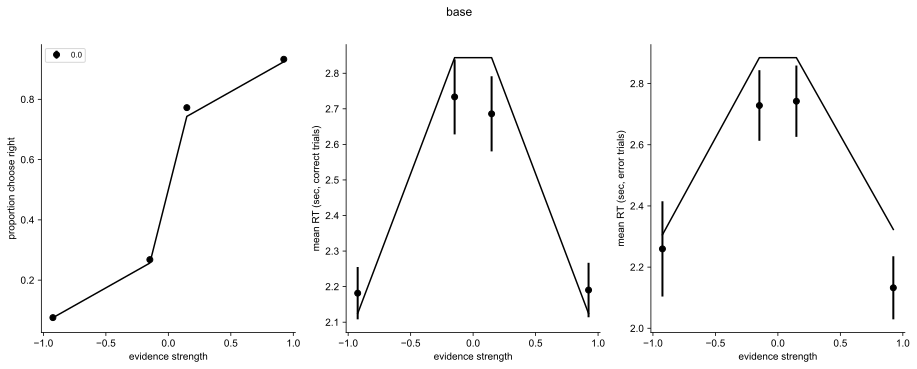

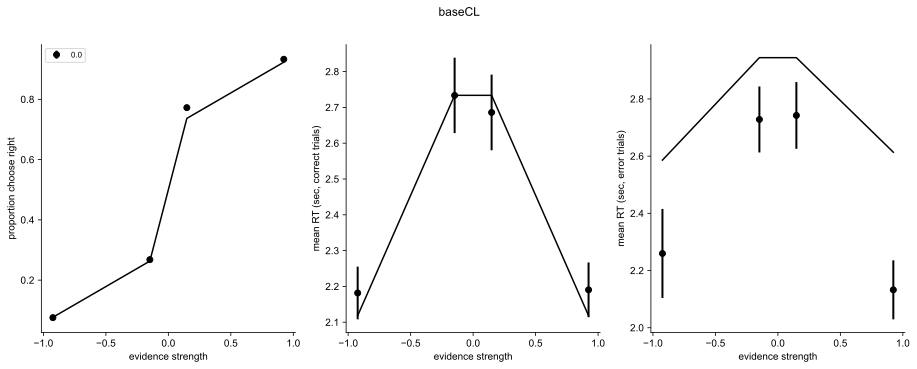

In [18]:
#merge predictions w/ data for analysis
for b,soldf in base_soldf.items():
    
    databi = ddm_corr.data_pred_merge(datat.loc[datat.rho==0.0],soldf,on=['subject','rho','mu'])
    
    databi_psycho_ave = databi[['subject','rho','SNR','mu','response','pred_response']].groupby(['subject','rho','SNR','mu']).agg(['mean','std','sem'])

    databi_chrono_ave = \
        databi[['subject','rho','SNR','mu','correct','RT','mean_RT_corr','mean_RT_err']].groupby(['subject','rho','SNR','mu','correct']).agg(['mean','median','std','sem'])

    #now plot average over subjects
    databi_psycho_ave_all = \
        databi_psycho_ave.xs('mean',axis=1,level=1).join(subj_SNR,on=['subject','SNR']).groupby(['rho','uSNR']).agg(['mean','std','sem'])
    display(databi_psycho_ave_all.head())

    databi_chrono_ave_all = \
        databi_chrono_ave.xs('mean',axis=1,level=1).join(subj_SNR,on=['subject','SNR']).groupby(['rho','uSNR','correct']).agg(['mean','std','sem'])
    display(databi_chrono_ave_all.head())

    fig,ax=plot_psycho_chrono_ave(databi_psycho_ave_all,databi_chrono_ave_all)
    plt.suptitle(b)

### paper plot

   trial                   subject  rho       mu      RT  response  correct  \
0      3  5f3ee36d0306de1a411882a5  0.0 -0.01889  2.4702       0.0      1.0   
1     21  5f3ee36d0306de1a411882a5  0.0 -0.01889  3.4319       1.0      0.0   
2     32  5f3ee36d0306de1a411882a5  0.0 -0.01889  5.1892       1.0      0.0   
3     44  5f3ee36d0306de1a411882a5  0.0 -0.01889  1.8299       1.0      0.0   
4     56  5f3ee36d0306de1a411882a5  0.0 -0.01889  2.4705       1.0      0.0   

     SNRraw  threshold  rho_cond   SNR  mean_corr  mean_err  mean_RT_corr  \
0 -0.142733   0.356901       0.2 -0.14   0.733499  0.266501      2.846691   
1 -0.142733   0.356901       0.2 -0.14   0.733499  0.266501      2.846691   
2 -0.142733   0.356901       0.2 -0.14   0.733499  0.266501      2.846691   
3 -0.142733   0.356901       0.2 -0.14   0.733499  0.266501      2.846691   
4 -0.142733   0.356901       0.2 -0.14   0.733499  0.266501      2.846691   

   mean_RT_err model  pred_response  
0     3.073453  base    

response                     pred_response                      \
                 mean       std       sem          mean       std       sem   
rho uSNR                                                                      
0.0 -0.9239  0.075545  0.056731  0.005673      0.075305  0.042363  0.004236   
    -0.1480  0.267933  0.096548  0.009655      0.256634  0.050404  0.005040   
     0.1480  0.772412  0.080849  0.008085      0.743366  0.050404  0.005040   
     0.9239  0.932959  0.053089  0.005309      0.924695  0.042363  0.004236   

            rSNR            
            mean  std  sem  
rho uSNR                    
0.0 -0.9239  1.0  0.0  0.0  
    -0.1480  2.0  0.0  0.0  
     0.1480  3.0  0.0  0.0  
     0.9239  4.0  0.0  0.0

RT                     mean_RT_corr            \
                         mean       std       sem         mean       std   
rho uSNR    correct                                                        
0.0 -0.9239 0.0      2.259547  1.493308  0.155688     2.051587  0.657398   
            1.0      2.181604  0.735463  0.073546     2.124468  0.695126   
    -0.1480 0.0      2.728161  1.153973  0.115397     2.843819  1.053266   
            1.0      2.733466  1.054133  0.105413     2.843819  1.053266   
     0.1480 0.0      2.742214  1.166033  0.116603     2.843819  1.053266   

                              mean_RT_err                     rSNR            
                          sem        mean       std       sem mean  std  sem  
rho uSNR    correct                                                           
0.0 -0.9239 0.0      0.068538    2.305676  0.758235  0.079051  1.0  0.0  0.0  
            1.0      0.069513    2.386045  0.811331  0.081133  1.0  0.0  0.0  
    -0.1480 0.0      0.105327    2.884597  1.050968  0.105097  2.0  0.0  0.0  
            1.0      0.105327    2.884597  1.050968  0.105097  2.0  0.0  0.0  
     0.1480 0.0      0.105327    2.884597  1.050968  0.105097  3.0  0.0  0.0

   trial                   subject  rho       mu      RT  response  correct  \
0      3  5f3ee36d0306de1a411882a5  0.0 -0.01889  2.4702       0.0      1.0   
1     21  5f3ee36d0306de1a411882a5  0.0 -0.01889  3.4319       1.0      0.0   
2     32  5f3ee36d0306de1a411882a5  0.0 -0.01889  5.1892       1.0      0.0   
3     44  5f3ee36d0306de1a411882a5  0.0 -0.01889  1.8299       1.0      0.0   
4     56  5f3ee36d0306de1a411882a5  0.0 -0.01889  2.4705       1.0      0.0   

     SNRraw  threshold  rho_cond   SNR  mean_corr  mean_err  mean_RT_corr  \
0 -0.142733   0.356901       0.2 -0.14    0.72963   0.27037      2.772548   
1 -0.142733   0.356901       0.2 -0.14    0.72963   0.27037      2.772548   
2 -0.142733   0.356901       0.2 -0.14    0.72963   0.27037      2.772548   
3 -0.142733   0.356901       0.2 -0.14    0.72963   0.27037      2.772548   
4 -0.142733   0.356901       0.2 -0.14    0.72963   0.27037      2.772548   

   mean_RT_err   model  pred_response  
0     3.118984  baseCL

response                     pred_response                      \
                 mean       std       sem          mean       std       sem   
rho uSNR                                                                      
0.0 -0.9239  0.075545  0.056731  0.005673      0.076777  0.043589  0.004359   
    -0.1480  0.267933  0.096548  0.009655      0.263199  0.048146  0.004815   
     0.1480  0.772412  0.080849  0.008085      0.736801  0.048146  0.004815   
     0.9239  0.932959  0.053089  0.005309      0.923223  0.043589  0.004359   

            rSNR            
            mean  std  sem  
rho uSNR                    
0.0 -0.9239  1.0  0.0  0.0  
    -0.1480  2.0  0.0  0.0  
     0.1480  3.0  0.0  0.0  
     0.9239  4.0  0.0  0.0

RT                     mean_RT_corr            \
                         mean       std       sem         mean       std   
rho uSNR    correct                                                        
0.0 -0.9239 0.0      2.259547  1.493308  0.155688     2.044588  0.659910   
            1.0      2.181604  0.735463  0.073546     2.118239  0.699271   
    -0.1480 0.0      2.728161  1.153973  0.115397     2.733694  1.012039   
            1.0      2.733466  1.054133  0.105413     2.733694  1.012039   
     0.1480 0.0      2.742214  1.166033  0.116603     2.733694  1.012039   

                              mean_RT_err                     rSNR            
                          sem        mean       std       sem mean  std  sem  
rho uSNR    correct                                                           
0.0 -0.9239 0.0      0.068800    2.586015  0.943924  0.098411  1.0  0.0  0.0  
            1.0      0.069927    2.723922  1.061213  0.106121  1.0  0.0  0.0  
    -0.1480 0.0      0.101204    2.944259  1.127155  0.112715  2.0  0.0  0.0  
            1.0      0.101204    2.944259  1.127155  0.112715  2.0  0.0  0.0  
     0.1480 0.0      0.101204    2.944259  1.127155  0.112715  3.0  0.0  0.0

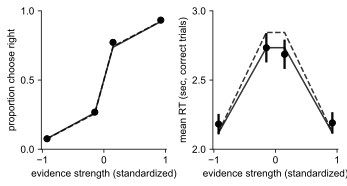

In [19]:
plot_mods = ['base','baseCL']
plot_lns = {'base': '--','baseCL':'-'}

fig,ax = plt.subplots(nrows=1,ncols=2,sharex=True)
for modi in plot_mods:
    soldf = base_soldf[modi]
    
    databi = ddm_corr.data_pred_merge(datat.loc[datat.rho==0.0],soldf,on=['subject','rho','mu'])
    
    databi_psycho_ave = databi[['subject','rho','SNR','mu','response','pred_response']].groupby(['subject','rho','SNR','mu']).agg(['mean','std','sem'])

    databi_chrono_ave = \
        databi[['subject','rho','SNR','mu','correct','RT','mean_RT_corr','mean_RT_err']].groupby(['subject','rho','SNR','mu','correct']).agg(['mean','median','std','sem'])

    #now plot average over subjects
    databi_psycho_ave_all = \
        databi_psycho_ave.xs('mean',axis=1,level=1).join(subj_SNR,on=['subject','SNR']).groupby(['rho','uSNR']).agg(['mean','std','sem'])
    display(databi_psycho_ave_all.head())

    databi_chrono_ave_all = \
        databi_chrono_ave.xs('mean',axis=1,level=1).join(subj_SNR,on=['subject','SNR']).groupby(['rho','uSNR','correct']).agg(['mean','std','sem'])
    display(databi_chrono_ave_all.head())

    plot_psycho_chrono_ave(databi_psycho_ave_all,databi_chrono_ave_all,ax=ax,
                           mod_line=plot_lns[modi],RT_err=False,alpha=0.8)
    #plt.suptitle(b)
ax[0].legend().set_visible(False)
ax[0].set_xticks([-1,0,1])
ax[0].set_ylim([0,1])
ax[0].set_yticks([0,0.5,1])
ax[0].set_xlabel('evidence strength (standardized)')

ax[1].set_ylim([2,3])
ax[1].set_yticks([2,2.5,3])
ax[1].set_xlabel('evidence strength (standardized)')
    
fig.set_figwidth(12.5*cm)
fig.set_figheight(6.77*cm)
fig.tight_layout()

fig.savefig(path.join(fig_dir,'fig6_SUPP_basemods_%s.pdf' % date.today()))

## param analysis

In [20]:
#let's get params after all to get a better sense of what's happening here...
base_params = {}
for b,fits in base_fits.items():
    base_params[b] = ddm_corr.get_all_params(fits)


                  value hit_boundary                   subject
param                                                         
driftSNR      23.684597        False  613a8ef513f5e9934f6f6fb3
B              0.991315        False  613a8ef513f5e9934f6f6fb3
nondectime     0.501389        False  613a8ef513f5e9934f6f6fb3
umixturecoef   0.001000         True  613a8ef513f5e9934f6f6fb3
driftSNR      14.398363        False  613433e6d6d82dbdad53e847
              value hit_boundary                   subject
param                                                     
umixturecoef  0.001         True  613a8ef513f5e9934f6f6fb3
umixturecoef  0.001         True  5f6a825c6b0125156e8c1b5f
umixturecoef  0.001         True  60fead47231209607137f36e
umixturecoef  0.001         True  60fe1c233dd0ee9020efca7e
umixturecoef  0.001         True  5be7e1a00e366e000175e343
...             ...          ...                       ...
umixturecoef  0.001         True  613a3fa3cd445d55f2e1a486
umixturecoef  0.001         

In [21]:
#only hitting boundary on mins
for m,p in base_params.items():
    print(m)
    display(p.loc[p.hit_boundary].groupby('param').hit_boundary.value_counts())
    display(p.loc[p.hit_boundary].groupby('param').min())
    display(p.loc[p.hit_boundary].groupby('param').max())

base


param         hit_boundary
nondectime    True             1
umixturecoef  True            63
Name: hit_boundary, dtype: int64

,value,hit_boundary,subject
param,,,
nondectime,0.024074,True,616f469494656434f5b4ebc6
umixturecoef,0.001000,True,5b3455bf532e3d00018e6e8b


,value,hit_boundary,subject
param,,,
nondectime,0.024074,True,616f469494656434f5b4ebc6
umixturecoef,0.001668,True,6176846e673909995a32dce3


baseCL


param         hit_boundary
nondectime    True             4
t             True            41
umixturecoef  True            53
Name: hit_boundary, dtype: int64

,value,hit_boundary,subject
param,,,
nondectime,0.003943,True,5e95d4f551598d01d6d455af
t,0.000000,True,5b3455bf532e3d00018e6e8b
umixturecoef,0.001000,True,5b232f6838fc0c000131438c


,value,hit_boundary,subject
param,,,
nondectime,0.022846,True,616f469494656434f5b4ebc6
t,0.057064,True,616f469494656434f5b4ebc6
umixturecoef,0.002582,True,6176846e673909995a32dce3


In [22]:
#export fit stats
fiteval = [gdw.get_fit_stats(m) for fits in base_fits.values()
           for m in fits.values()]
fiteval = pd.DataFrame(fiteval)

#we didn't bother with which corr group they were in above, but let's merge that in here in case we want to use it
fiteval = fiteval.merge(subj,on='subject')

display(fiteval)

if False:
    fiteval.to_csv(path.join(path.join(fit_dir0,'base_fits_all_o00_%s.csv' % date.today())),index=False)             

,subject,model,nparams,nlle,bic,aic,rho_cond
0,613a8ef513f5e9934f6f6fb3,base,4,276.680184,575.541079,561.360369,0.2
1,613a8ef513f5e9934f6f6fb3,baseCL,5,272.398669,572.523225,554.797338,0.2
2,613433e6d6d82dbdad53e847,base,4,431.890055,885.960819,871.780109,0.2
3,613433e6d6d82dbdad53e847,baseCL,5,412.873606,853.473099,835.747212,0.2
4,6028191ed22ee868e11c5095,base,4,457.519719,937.220148,923.039439,0.4
...,...,...,...,...,...,...,...
195,5de42a01a7cb2401ccc682c3,baseCL,5,415.165109,858.056106,840.330218,0.8
196,611e0f3a4d0f7f5b8e58afa3,base,4,556.189321,1134.543696,1120.378642,0.6
197,611e0f3a4d0f7f5b8e58afa3,baseCL,5,551.470743,1130.647803,1112.941486,0.6
198,5fbab1a17fe54faddf522d85,base,4,296.229105,614.623263,600.458209,0.6
